In [ ]:
## Script Index: S7
## Author: Liu Yue
## Date: 10/10/2016
## Python Version: Anaconda 4.2.0, python 3.5

""" 
    This script runs model for devce model prioritization, 
    by checking the best cut-off for device_id_count 
    with RMSE for only measuring top device models
"""

In [1]:
import csv
import copy
import math
with open('S6_device model details.csv', newline='',encoding='utf-8') as f:
    file = csv.reader(f)
    device_model_details = list(file)
    
for line in device_model_details:
    numeric_index = {1,2,3,4,5,6,7,8,9,12,13}
    for i in numeric_index:
        line[i] = float(line[i])
        if int(str(line[i]).split('.')[1])==0:
            line[i] = int(line[i])
lst = device_model_details

lst2 =  copy.deepcopy(lst)
total_device_count = sum(line[12] for line in lst2)
print("Total number of devices for all device models:",total_device_count)
total_app_device_count = sum(line[13] for line in lst2)
print("Total number of devices with selected app installed:",total_app_device_count)
standard_rate = total_app_device_count/total_device_count
print("Weighted average installation rate:", round(standard_rate,3))

""" Select all 9 attributes """
lst2 = [[line[10:12]]+[line[1:10]]+[line[12:14]] for line in lst2]
lst2 = sorted(lst2, key=lambda line:line[2][0],reverse=True)

""" Check device models with the same attributes and merge"""
for line in lst2:
    device_model_name = line[0]
    for line2 in lst2:
        device_model_name2 = line2[0]
        if device_model_name!=device_model_name2 and line[1]==line2[1]:
            line[0] = device_model_name + device_model_name2
            line[2] = [line[2][0]+line2[2][0], line[2][1]+line2[2][1]]
            lst2.remove(line2)

Total number of devices for all device models: 56865
Total number of devices with selected app installed: 38291
Weighted average installation rate: 0.673


In [5]:
""" list of possible devicd_id_count """
device_id_count = sorted(list(set(line[2][0] for line in lst2)), key=lambda x:x)
print("Number of possible device_id_count:",len(device_id_count))

Number of possible device_id_count: 181


In [15]:
""" Only measuring top device models"""
import math
import heapq    
import copy
result =[]

for minminum_device_count in device_id_count[:179]:
    """"""
    lst3 =  copy.deepcopy(lst2)
    lst3 = [line for line in lst3 if line[2][0]>minminum_device_count]
    lst3 = sorted(lst3, key=lambda line:line[2][0],reverse=True)

    """ Add installation rate"""
    for line in lst3:
        installation_rate = line[2][1]/line[2][0]
        line.append([round(standard_rate,3),round(installation_rate,3)])

    """ Compute rmse for using average rate for prediction"""
    squared_error_average = 0
    for line in lst3:
        average = line[3][0]
        actual = line[3][1]
        squared_error_average += (average-actual)*(average-actual)
    rmse_average = math.sqrt(squared_error_average/len(lst3))

    """ Compute all similarity for divice models """
    from scipy import spatial
    sim_mat = []
    for line in lst3:
        sim_line = []
        for line2 in lst3:
            sim = 1 - spatial.distance.cosine(line[1], line2[1])
            sim_line.append(sim)
        sim_mat.append(sim_line) 

    def checking_error(lst3, prediction_index):
        """ Method to check the prediction error """
        count = 0
        squared_error_prediction = 0
        for line in lst3:
            average = line[3][0]
            actual = line[3][1]
            prediction = line[3][prediction_index+2]
            squared_error_prediction += (prediction-actual)*(prediction-actual)
            if abs(prediction-actual) < abs(average-actual):
                count+=1
        return(math.sqrt(squared_error_prediction/len(lst3)))

    prediction_index = 0
    rmse = []
    n = []

    for sim_n in range(1,30):  
        """ Find top n similarity """
        sim_val = [heapq.nlargest(sim_n+1, line) for line in sim_mat]
        sim_val = [line[1:] for line in sim_val]

        ## Get assignmed index of top N similar device model
        sim_name = []
        for i in range(0, len(sim_val)):
            sim_name.append([lst3[k][0] for k, j in enumerate(sim_mat[i]) if j in sim_val[i]])

        for i in range(0, len(lst3)):
            line = lst3[i]
            names = sim_name[i]
            vals = sim_val[i]
            id_count_sum = 0
            id_count_with_app = 0
            for line2 in lst3:       
                if line2[0] in names:            
                    id_count_sum += line2[2][0]
                    id_count_with_app += line2[2][1]
            line[3].append(round(id_count_with_app/id_count_sum,3))    
        n.append(sim_n)
        rmse.append(checking_error(lst3, prediction_index))
        prediction_index+=1
        
    rmse_min = round(min(rmse),3),
    n_rmse_min = [n[i] for i, j in enumerate(rmse) if j == min(rmse)]

    result.append([minminum_device_count,rmse_average,rmse_min,n_rmse_min])

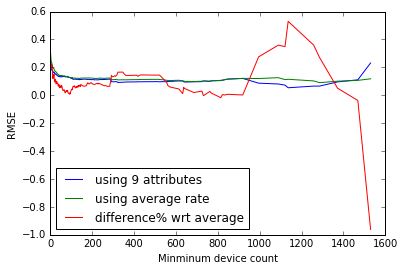

Minimum RMSE using all attributes to predict is 0.054 when device count > 1136 for predicting using most [2] similar models
RMSE of using all attributes to predict differs the most from RMSE of using average rate to predict when device count > 1136 for predicting using most [2] similar models
RMSE is reduces from 0.115 to 0.054


In [21]:
"""plot Minimum RMSE vs minminum_device_count"""
import matplotlib.pyplot as plt
%matplotlib inline
plt.ylabel('RMSE')
plt.xlabel('Minminum device count')

legend = ["using 9 attributes","using average rate","difference% wrt average"]
n = [line[3] for line in result]
rmse_average = [line[1] for line in result]
rmse_attributes = [line[2][0] for line in result]
rmse_percentage_difference = [(line[1]-line[2][0])/line[1] for line in result]
minminum_device_count = [line[0] for line in result]
plt.plot(minminum_device_count, rmse_attributes)
plt.plot(minminum_device_count, rmse_average)
plt.plot(minminum_device_count, rmse_percentage_difference)

plt.legend(legend, loc='lower left')
plt.show()
print("Minimum RMSE using all attributes to predict is",round(min(rmse_attributes),3), 
      "when device count >", [minminum_device_count[i] for i, j in enumerate(rmse_attributes) if j == min(rmse_attributes)][0],
      "for predicting using most", [n[i] for i, j in enumerate(rmse_attributes) if j == min(rmse_attributes)][0],"similar models")
print("RMSE of using all attributes to predict differs the most from RMSE of using average rate to predict",
      "when device count >", [minminum_device_count[i] for i, j in enumerate(rmse_percentage_difference) if j == max(rmse_percentage_difference)][0],
      "for predicting using most", [n[i] for i, j in enumerate(rmse_percentage_difference) if j == max(rmse_percentage_difference)][0],
      "similar models\nRMSE is reduces from", 
      round([rmse_average[i] for i, j in enumerate(rmse_percentage_difference) if j == max(rmse_percentage_difference)][0],3),
     "to", [rmse_attributes[i] for i, j in enumerate(rmse_percentage_difference) if j == max(rmse_percentage_difference)][0])

In [20]:
print("For Min RMSE, number of top device models considered:",len([line for line in lst2 if line[2][0]>1136]))

For Min RMSE, number of top device models considered: 7


In [27]:
[line for line in lst2 if line[2][0]>1136]

[[['小米', '红米note'], [5.5, 720, 1300, 500, 4, 1, 3100, 14, 650], [2443, 1418]],
 [['小米', 'MI 4'], [5, 1080, 1300, 800, 4, 3, 3080, 19, 1150], [2232, 1812]],
 [['三星', 'Galaxy Note 3'],
  [5.7, 1080, 1300, 200, 4, 3, 3200, 33, 1100],
  [1530, 1152]],
 [['华为', '荣耀6'], [5, 1080, 1300, 500, 8, 3, 3100, 23, 1250], [1469, 1108]],
 [['小米', 'MI 3'], [5, 1080, 1300, 200, 4, 2, 3050, 32, 700], [1372, 912]],
 [['华为', 'Mate 7'], [6, 1080, 1300, 500, 8, 3, 4100, 20, 1600], [1286, 1060]],
 [['华为', '荣耀畅玩4X'], [5.5, 720, 1300, 500, 8, 2, 3000, 11, 650], [1258, 634]]]

In [28]:
sum([line[2][0] for line in lst2 if line[2][0]>1136])

11590

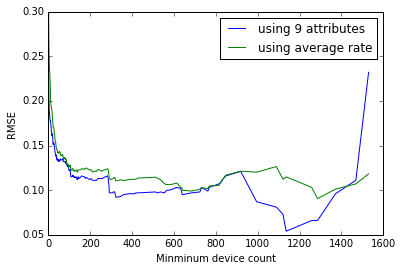

In [14]:
"""plot Minimum RMSE vs minminum_device_count"""
import matplotlib.pyplot as plt
%matplotlib inline
plt.ylabel('RMSE')
plt.xlabel('Minminum device count')

legend = ["using 9 attributes","using average rate"]
n = [line[3] for line in result]
rmse_average = [line[1] for line in result]
rmse_attributes = [line[2][0] for line in result]
rmse_percentage_difference = [(line[1]-line[2][0])/line[1] for line in result]
minminum_device_count = [line[0] for line in result]
plt.plot(minminum_device_count, rmse_attributes)
plt.plot(minminum_device_count, rmse_average)

plt.legend(legend, loc='best')
plt.show()

In [23]:
print("minminum_device_count, rmse_average, rmse_min, n_rmse_min")
result

minminum_device_count, rmse_average, rmse_min, n_rmse_min


[[1, 0.29781680549464723, (0.229,), [6]],
 [2, 0.27077562776967096, (0.208,), [5]],
 [3, 0.2533660562425092, (0.196,), [5]],
 [4, 0.24244015286823323, (0.189,), [5]],
 [5, 0.23542767905835948, (0.186,), [5]],
 [6, 0.23140533801875918, (0.184,), [6]],
 [7, 0.22969775477354878, (0.18,), [4]],
 [8, 0.22278691602122594, (0.178,), [5]],
 [9, 0.2139280621832341, (0.178,), [4]],
 [10, 0.2070061519890797, (0.176,), [5]],
 [11, 0.1982115279146773, (0.174,), [5]],
 [12, 0.1954103636202804, (0.172,), [4]],
 [13, 0.1936309103626091, (0.168,), [4]],
 [14, 0.19237635072290027, (0.166,), [4]],
 [15, 0.19118059405696472, (0.165,), [3]],
 [16, 0.18996978317226798, (0.163,), [4]],
 [17, 0.18963536180453106, (0.161,), [3]],
 [18, 0.18502865027743012, (0.163,), [4]],
 [19, 0.18253213931814302, (0.162,), [4]],
 [20, 0.1767599762936476, (0.16,), [3]],
 [21, 0.1754635626905514, (0.156,), [3]],
 [22, 0.17091480055167554, (0.152,), [3]],
 [23, 0.17059200762203403, (0.151,), [3]],
 [24, 0.1703504720666583, (0.1